# Import bibliotek

In [1]:
import fastf1
import fastf1.plotting
import pandas as pd
import sys
import matplotlib as mpl
import time
import dask
from tqdm.auto import tqdm
import numpy as np
import plotly.express as px
import os
from matplotlib.collections import LineCollection
from datetime import timedelta
from statistics import mean
from IPython.utils import io
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_csv('https://1drv.ms/u/s!AiFZTOUI8ht5gaMKQbCRFw79CCHoEg?e=WLRVmo')
df

ParserError: Error tokenizing data. C error: Expected 1 fields in line 5, saw 5


# DF sources import:
- schedule
- session.drivers: get drivers
- session.laps.pick_driver(DRIVER).get_telemetry() - telemetry data
- session.laps['Lap number','Lapt start time', 'Lap time'] to get the current lap


## Schedule

In [2]:
fastf1.Cache.offline_mode(True)
schedule=fastf1.get_event_schedule(2023, include_testing=False)
schedule.head()

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: C:\Users\mathi\AppData\Local\Temp\fastf1.
	Size: 2.36 GB


,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,Session2,Session2Date,Session2DateUtc,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
1,1,Bahrain,Sakhir,FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2023,2023-03-05,Bahrain Grand Prix,conventional,Practice 1,2023-03-03 14:30:00+03:00,2023-03-03 11:30:00,Practice 2,2023-03-03 18:00:00+03:00,2023-03-03 15:00:00,Practice 3,2023-03-04 14:30:00+03:00,2023-03-04 11:30:00,Qualifying,2023-03-04 18:00:00+03:00,2023-03-04 15:00:00,Race,2023-03-05 18:00:00+03:00,2023-03-05 15:00:00,True
2,2,Saudi Arabia,Jeddah,FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2023,2023-03-19,Saudi Arabian Grand Prix,conventional,Practice 1,2023-03-17 16:30:00+03:00,2023-03-17 13:30:00,Practice 2,2023-03-17 20:00:00+03:00,2023-03-17 17:00:00,Practice 3,2023-03-18 16:30:00+03:00,2023-03-18 13:30:00,Qualifying,2023-03-18 20:00:00+03:00,2023-03-18 17:00:00,Race,2023-03-19 20:00:00+03:00,2023-03-19 17:00:00,True
3,3,Australia,Melbourne,FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2023,2023-04-02,Australian Grand Prix,conventional,Practice 1,2023-03-31 12:30:00+10:00,2023-03-31 02:30:00,Practice 2,2023-03-31 16:00:00+10:00,2023-03-31 06:00:00,Practice 3,2023-04-01 12:30:00+10:00,2023-04-01 02:30:00,Qualifying,2023-04-01 16:00:00+10:00,2023-04-01 06:00:00,Race,2023-04-02 15:00:00+10:00,2023-04-02 05:00:00,True
4,4,Azerbaijan,Baku,FORMULA 1 AZERBAIJAN GRAND PRIX 2023,2023-04-30,Azerbaijan Grand Prix,sprint_shootout,Practice 1,2023-04-28 13:30:00+04:00,2023-04-28 09:30:00,Qualifying,2023-04-28 17:00:00+04:00,2023-04-28 13:00:00,Sprint Shootout,2023-04-29 12:30:00+04:00,2023-04-29 08:30:00,Sprint,2023-04-29 17:30:00+04:00,2023-04-29 13:30:00,Race,2023-04-30 15:00:00+04:00,2023-04-30 11:00:00,True
5,5,United States,Miami,FORMULA 1 CRYPTO.COM MIAMI GRAND PRIX 2023,2023-05-07,Miami Grand Prix,conventional,Practice 1,2023-05-05 14:00:00-04:00,2023-05-05 18:00:00,Practice 2,2023-05-05 17:30:00-04:00,2023-05-05 21:30:00,Practice 3,2023-05-06 12:30:00-04:00,2023-05-06 16:30:00,Qualifying,2023-05-06 16:00:00-04:00,2023-05-06 20:00:00,Race,2023-05-07 15:30:00-04:00,2023-05-07 19:30:00,True


## Race telemetry for all drivers

```python
rounds=schedule['RoundNumber'].tolist()
for round_no in tqdm(rounds,desc='Round'):
    name=schedule.loc[schedule['RoundNumber']==round_no,'Location'].iloc[0]
    session = fastf1.get_session(2023, round_no, 'R')
    session.load(laps=True, telemetry=True,weather=False, messages=False)
    clear_output(wait=True)
    cars=session.drivers
    max_laps=session.laps['LapNumber'].max()
    df_master=pd.DataFrame(columns=['Driver','Lap'])
    print(round_no,'/',len(rounds))
    for car in tqdm(cars,desc='Cars'):
        for lap in tqdm(np.arange(1,max_laps+1),desc='Lap'):
            if session.laps.pick_driver(car).pick_laps(lap).shape[0]>0:
                d_tel=session.laps.pick_driver(car).pick_laps(lap).get_telemetry()
                if car!=cars[0]:
                    d_tel=d_tel.loc[d_tel['Date'].isin(timestamps)]
                df_master=pd.concat([df_master,d_tel],ignore_index=True)
                df_master.fillna({'Driver':car,'Lap':lap},inplace=True)
        if car==cars[0]:
            df_master=df_master.iloc[::100]
            timestamps=df_master['Date'].tolist()
    df_master.to_csv('Data/CSV/{}.csv'.format(name))
    
    
df_master
```

## Positions

``` python
positions =[]
for index, row in tqdm(df_master.iterrows(),total=df_master.shape[0]):
    driver_a = row['DriverAhead']
    position = 1  # Default position
    driver_list=[driver_a]
    while len(driver_a)>=1:
        driver_info = df_master.loc[(df_master['Date'] == row['Date'])&(df_master['Driver'] == driver_a)]
        driver_a = driver_info['DriverAhead'].iloc[0]
        if driver_a in driver_list:
            break
        else:
            driver_list.append(driver_a)

    positions.append(len(driver_list))

df_master['Position'] = positions
```

# Preprocessing

## Acceleration

``` python
df_aux=d_tel[['Speed','Time']]
time=df_aux.iloc[2,1]
df_aux['Sec']=df_aux['Time'].dt.total_seconds()
df_aux['Acceleration']=df_aux['Speed'].diff()/df_aux['Sec'].diff()/9.81/3.6
df_aux['Acceleration']=df_aux['Acceleration'].round(2)

clear_output(wait=False)
print(df_aux['Acceleration'].max())
df_aux.head()
df_aux.set_index('Sec',inplace=True)
df_aux[['Speed']].plot()
df_aux[['Acceleration']].plot()
```

## Drivers names

In [388]:
rounds=schedule['RoundNumber'].tolist()
df_concat=[]
for round_no in tqdm(rounds,desc='Round'):
    session = fastf1.get_session(2023, round_no, 'R')
    session.load(laps=True, telemetry=False,weather=False, messages=False)
    clear_output(wait=True)
    drv_no=session.laps['Driver'].unique()
    full_names=[]
    for drv in drv_no:
        try:
            full_names.append(session.get_driver(drv)['FullName'])
        except:
            name=input(drv)
            full_names.append(name)
    df2=pd.DataFrame({'DriverNumber':drv_no,'FullName':full_names})
    df_concat.append(df2)
df_concat=pd.concat(df_concat,ignore_index=True)
df_concat.drop_duplicates(inplace=True)
df_concat.to_csv('Data/CSV/Drivers.csv')

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.1.6]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']


## Speed per lap

### Basic approach

In [ ]:
new_columns=['Max Speed','Min Speed','Mean Speed','Velocity','Timedelta','Distance','X','Y']
rounds=schedule['RoundNumber'].tolist()

for round_no in tqdm(rounds,desc='Round'):

    name=schedule.loc[schedule['RoundNumber']==round_no,'Location'].iloc[0]
    
    session = fastf1.get_session(2023, round_no, 'R');
    session.load(laps=True, telemetry=True,weather=False, messages=False)

    df=session.laps
    cars=df['DriverNumber'].unique()
    max_laps=session.laps['LapNumber'].max()
    for col in new_columns:    
        df[col]=None
    print(name,round_no,'/',len(rounds))
    for car in tqdm(cars,desc='Cars'):
        for lap in tqdm(np.arange(1,max_laps+1),desc='Lap'):
            if session.laps.pick_driver(car).pick_laps(lap).shape[0]>0:
                index=df.loc[(df['DriverNumber'] == car) & (df['LapNumber'] == lap)].index[0]
                d_tel=session.laps.pick_driver(car).pick_laps(lap).get_telemetry()
                d_tel['Time']=pd.to_timedelta(d_tel['Time']).dt.total_seconds()
                timedelta=d_tel['Time'].tolist()
                velocity=d_tel['Speed'].tolist()
                distance=d_tel['RelativeDistance'].tolist()
                x=d_tel['X'].tolist()
                y=d_tel['Y'].tolist()
                v_min=min(velocity)
                v_max=max(velocity)
                v_avg=round(mean(velocity),2)
                values = [v_max,v_min,v_avg,velocity,timedelta,distance,x,y]
                my_dict = dict(zip(new_columns, values))
                for key, value in my_dict.items():
                    df.at[index,key]=value
    df.to_csv('Data/CSV/{}.csv'.format(name))
    

### Dask

In [ ]:
new_columns = ['Max Speed', 'Min Speed', 'Mean Speed', 'Velocity', 'Timedelta', 'Distance', 'X', 'Y']
rounds = schedule['RoundNumber'].tolist()

@dask.delayed
def process_round(round_no):
    name = schedule.loc[schedule['RoundNumber'] == round_no, 'Location'].iloc[0]
    session = fastf1.get_session(2023, round_no, 'R')
    session.load(laps=True, telemetry=True, weather=False, messages=False)

    df = session.laps
    cars = df['DriverNumber'].unique()
    max_laps = session.laps['LapNumber'].max()

    for col in new_columns:
        df[col] = None

    print(name, round_no, '/', len(rounds))
    for car in tqdm(cars, desc='Cars'):
        for lap in tqdm(np.arange(1, max_laps + 1), desc='Lap'):
            if session.laps.pick_driver(car).pick_laps(lap).shape[0] > 0:
                index = df.loc[(df['DriverNumber'] == car) & (df['LapNumber'] == lap)].index[0]
                d_tel = session.laps.pick_driver(car).pick_laps(lap).get_telemetry()
                d_tel['Time'] = pd.to_timedelta(d_tel['Time']).dt.total_seconds()
                timedelta = d_tel['Time'].tolist()
                velocity = d_tel['Speed'].tolist()
                distance = d_tel['RelativeDistance'].tolist()
                x = d_tel['X'].tolist()
                y = d_tel['Y'].tolist()
                v_min = min(velocity)
                v_max = max(velocity)
                v_avg = round(mean(velocity), 2)
                values = [v_max, v_min, v_avg, velocity, timedelta, distance, x, y]
                my_dict = dict(zip(new_columns, values))
                for key, value in my_dict.items():
                    df.at[index, key] = value
    destination=f'Data/CSV/Dask/{name}.csv'
    df.to_csv(destination)
    return destination
    
# Parallelize the outer loop
delayed_tasks = [process_round(round_no) for round_no in rounds]
dask.compute(delayed_tasks)

### Apply

```python
rounds=schedule['RoundNumber'].tolist()

def full(car,lap):
    d_tel=seesion.laps.pick_driver(car).pick_laps(lap).get_telemetry()
    d_tel['Time']=pd.to_timedelta(d_tel['Time']).dt.total_seconds()
    timedelta=d_tel['Time'].tolist()
    velocity=d_tel['Speed'].tolist()
    v_min=min(velocity)
    v_max=max(velocity)
    v_avg=round(mean(velocity),2)
    values = [v_max,v_min,v_avg,velocity,timedelta]
    my_dict = dict(zip(new_columns, values))
    for key, value in my_dict.items():
        df.at[index,key]=value

def Vel(car,lap,df):
    print(car,lap)
    if df.pick_driver(car).pick_laps(lap).shape[0]>0:
        d_tel=df.pick_driver(car).pick_laps(lap).get_telemetry()
        d_tel['Time']=pd.to_timedelta(d_tel['Time']).dt.total_seconds()
        velocity=d_tel['Speed'].tolist()
        return velocity
        
def Time(car,lap,df):
    if df.pick_driver(car).pick_laps(lap).shape[0]>0:
        d_tel=df.pick_driver(car).pick_laps(lap).get_telemetry()
        d_tel['Time']=pd.to_timedelta(d_tel['Time']).dt.total_seconds()
        timedelta=d_tel['Time'].tolist()
        return timedelta



for round_no in tqdm(rounds,desc='Round'):
    name=schedule.loc[schedule['RoundNumber']==round_no,'Location'].iloc[0]
    session = fastf1.get_session(2023, round_no, 'R')
    session.load(laps=True, telemetry=True,weather=False, messages=False)
    clear_output(wait=True)
    cars=session.drivers
    max_laps=session.laps['LapNumber'].max()
    df=session.laps
    df['Velocity']=df.apply(lambda x: Vel(x['DriverNumber'],x['LapNumber'],df),axis=1)
    
    print(name,round_no,'/',len(rounds))
```

# Graphs
- Change in position
- Chenge in laptimes
- Tyre strategy so far
- V(time) for current driver and lap vs V_best_overall_lap(time)
- V_lap-V-best as contour on circuit
- Laptimes of current lap comparing tyres (boxplot)
- V_avg vs V_max for different teams

## Select inputs
- race name
- driver

In [3]:
Events_df = pd.DataFrame(glob('Data/CSV/*.csv'))
Events_df.rename(columns={0:'Path'},inplace=True)
Events_df['Event']=Events_df['Path'].str[len('Data/CSV/'):-4]
Events=Events_df['Event'].tolist()

event=Events[5]
print(event)

path=Events_df.loc[Events_df['Event']==event,'Path'].iloc[0]
df=pd.read_csv(path)
df.drop([col for col in df.columns.tolist() if 'Unnamed' in col],inplace=True,axis=1)
print(df['LapTime'].dtype)
df['LapTime']=pd.to_timedelta(df['LapTime'])
print(df['LapTime'].dtype)
df['LapTime']=df['LapTime'].dt.total_seconds()
print(df['LapTime'].dtype)

df['Color']= df['Driver'].apply(lambda x: fastf1.plotting.driver_color(x))

drivers=sorted(df['Driver'].unique())
driver=drivers[4]
print(driver)

laps=sorted(df['LapNumber'].unique())
lap=laps[10]
print(lap)

df.head(2)

Las Vegas
object
timedelta64[ns]
float64
HAM
11.0


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,Max Speed,Min Speed,Mean Speed,Velocity,Timedelta,Distance,X,Y,Color
0,0 days 00:15:48.822000,VER,1,105.670,1.0,1.0,NaN,NaN,NaN,0 days 00:00:33.497000,0 days 00:00:38.249000,NaN,0 days 00:15:10.604000,0 days 00:15:48.822000,176.0,204.0,297.0,278.0,False,MEDIUM,1.0,True,Red Bull Racing,0 days 00:14:02.793000,2023-11-19 06:04:05.010,26.0,1.0,NaN,NaN,False,False,326,0,206.13,"[0, 0, 0, 0, 1, 2, 4, 10, 17, 23, 30, 33, 36, ...","[0.0, 0.134, 0.334, 0.374, 0.514, 0.634, 0.654...","[4.036579650200135e-07, 0.0, -1.42035843173466...","[2440, 2442, 2442, 2441, 2442, 2443, 2443, 244...","[-191, -191, -191, -191, -191, -190, -189, -18...",#0600ef
1,0 days 00:18:01.833000,VER,1,133.011,2.0,1.0,NaN,NaN,0 days 00:00:39.773000,0 days 00:00:44.450000,0 days 00:00:48.788000,0 days 00:16:28.595000,0 days 00:17:13.045000,0 days 00:18:01.833000,158.0,186.0,295.0,197.0,True,MEDIUM,2.0,True,Red Bull Racing,0 days 00:15:48.822000,2023-11-19 06:05:51.039,67.0,1.0,NaN,NaN,False,False,301,65,164.82,"[287, 283, 274, 262, 251, 241, 229, 217, 211, ...","[0.0, 0.105, 0.106, 0.266, 0.445, 0.586, 0.746...","[-9.070357783765529e-05, 0.0011887023431013677...","[2116, 2160, 2160, 2214, 2262, 2325, 2403, 248...","[-598, -510, -509, -445, -392, -321, -234, -14...",#0600ef


## Change in laptimes

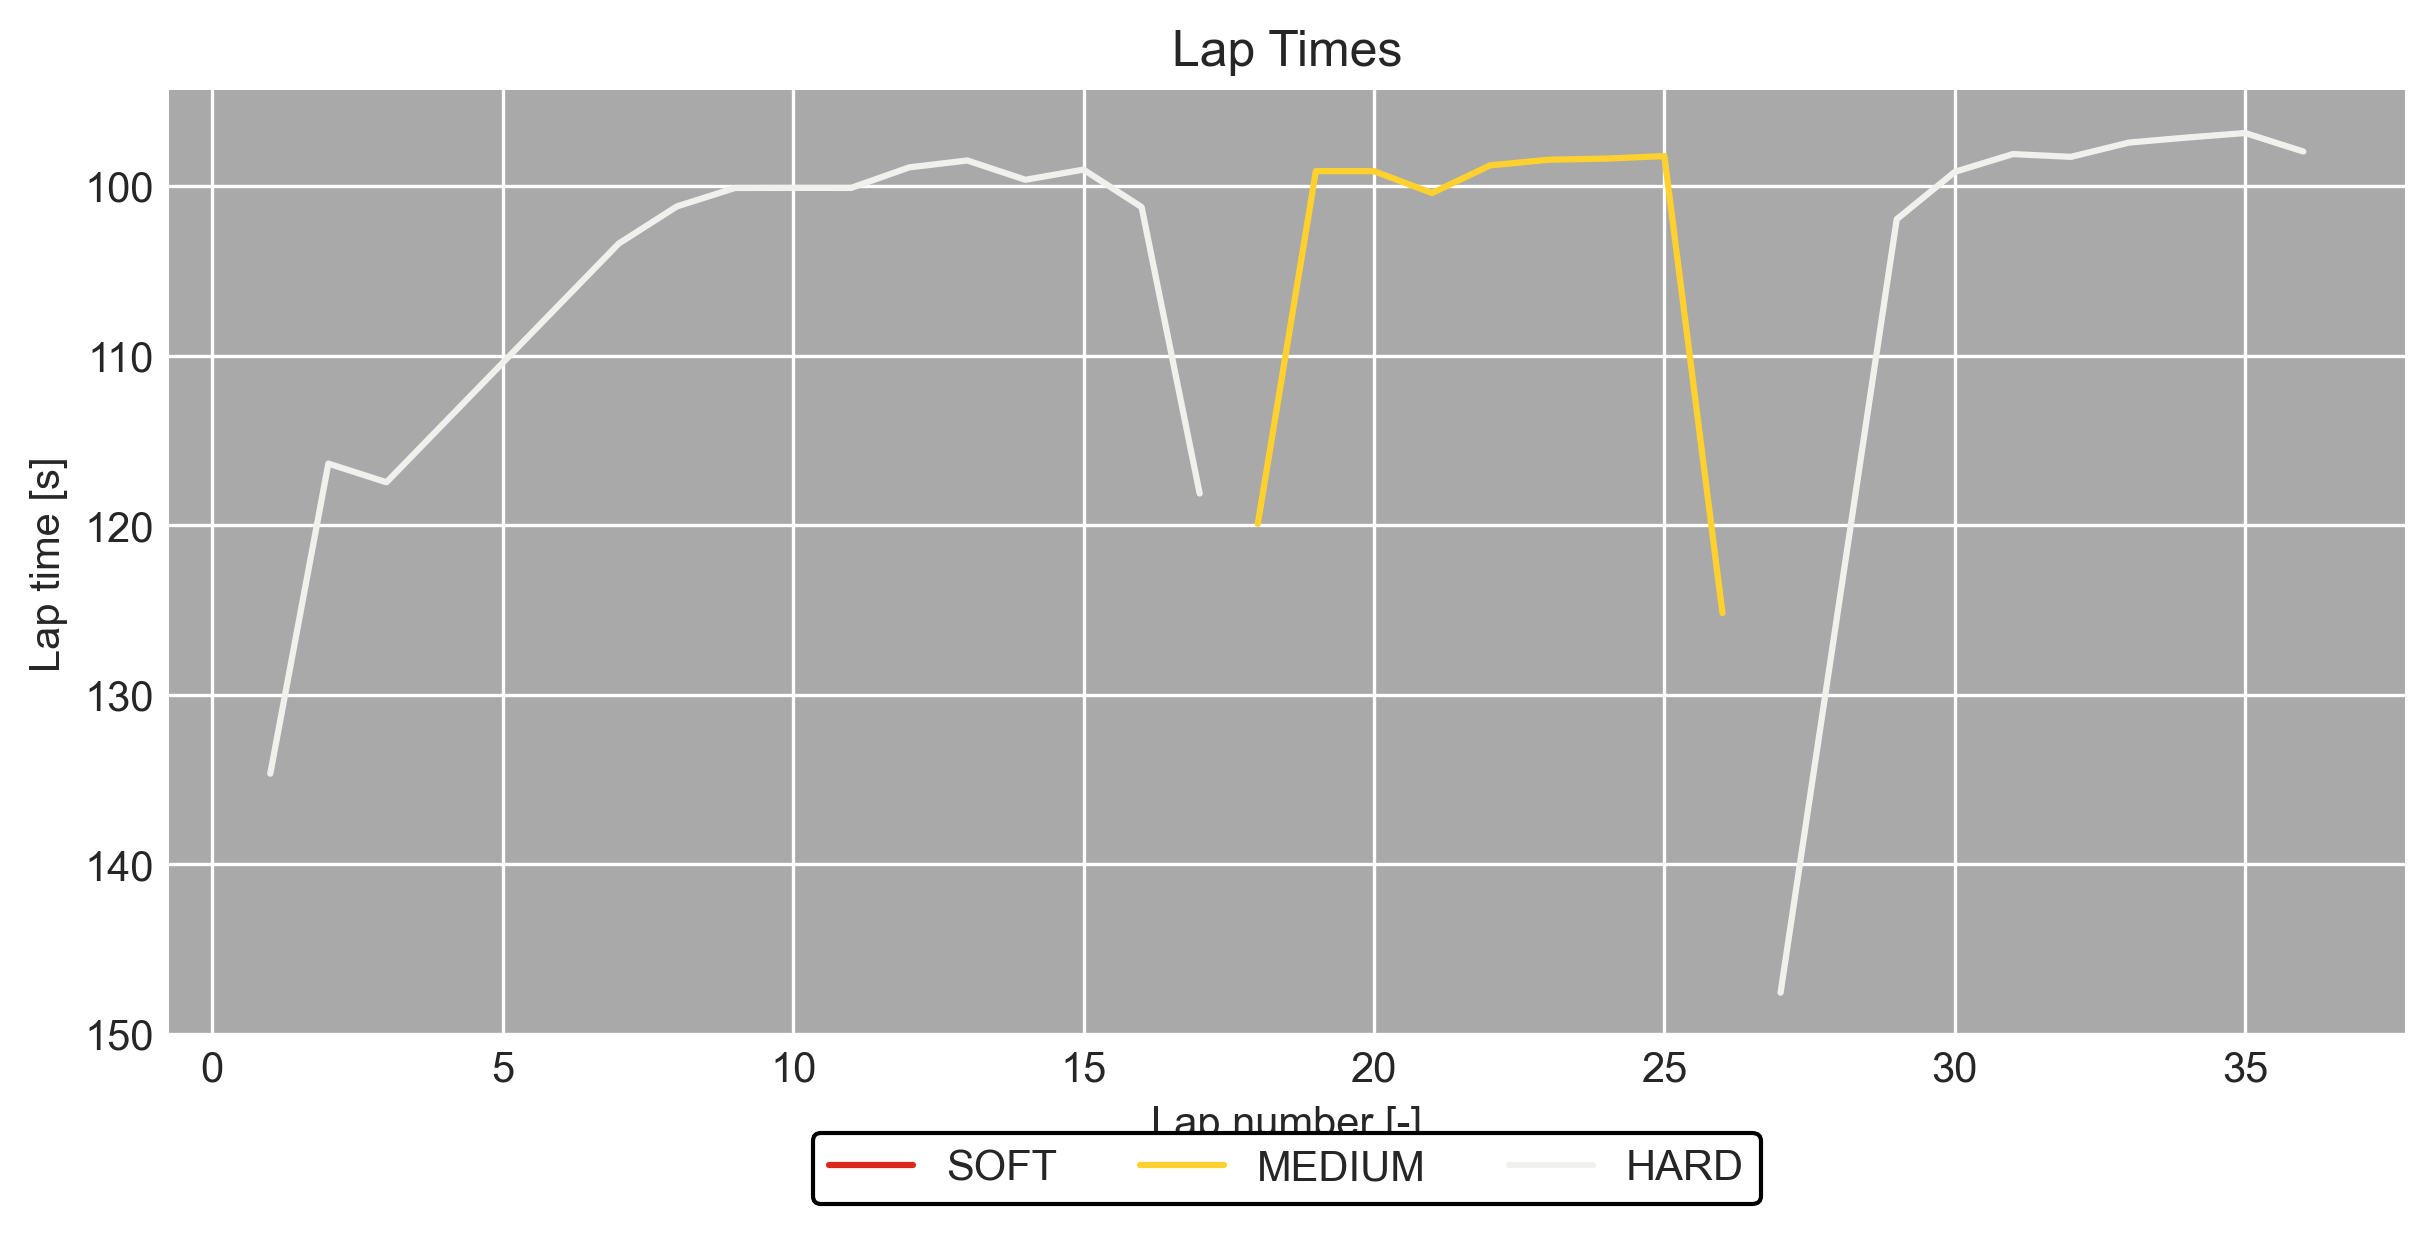

In [11]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
fig, axes = plt.subplots(figsize=(8, 4), dpi=300, layout='constrained')
axes.set_title('Lap Times')
axes.set_xlabel('Lap number [-]')
axes.set_ylabel('Lap time [s]')
axes.invert_yaxis()

sns_data=df.loc[(df['Driver']==driver)&(df['LapNumber']<=36)]
sns.lineplot(data=sns_data,x='LapNumber',y='LapTime',hue='Compound',style='Stint',dashes=False,ax=axes
             ,palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"])

tmp = axes.get_legend_handles_labels()

h = tmp[0][1:4]
l = tmp[1][1:4]
axes.legend(h, l, framealpha=1,
            frameon=True, edgecolor='black', facecolor='white', bbox_to_anchor=(0.5, -0.2), fontsize=10, loc='lower center', ncols=3)


In [15]:
import PIL
import io

def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img =PIL.Image.open(buf)
    plt.close(fig)
    return PIL.Image.open(buf)
img=buffer_plot_and_get(fig)
img.show()

## Change in position

<Axes: title={'center': 'Postion change up to this lap'}, xlabel='Lap number [-]', ylabel='Position [-]'>

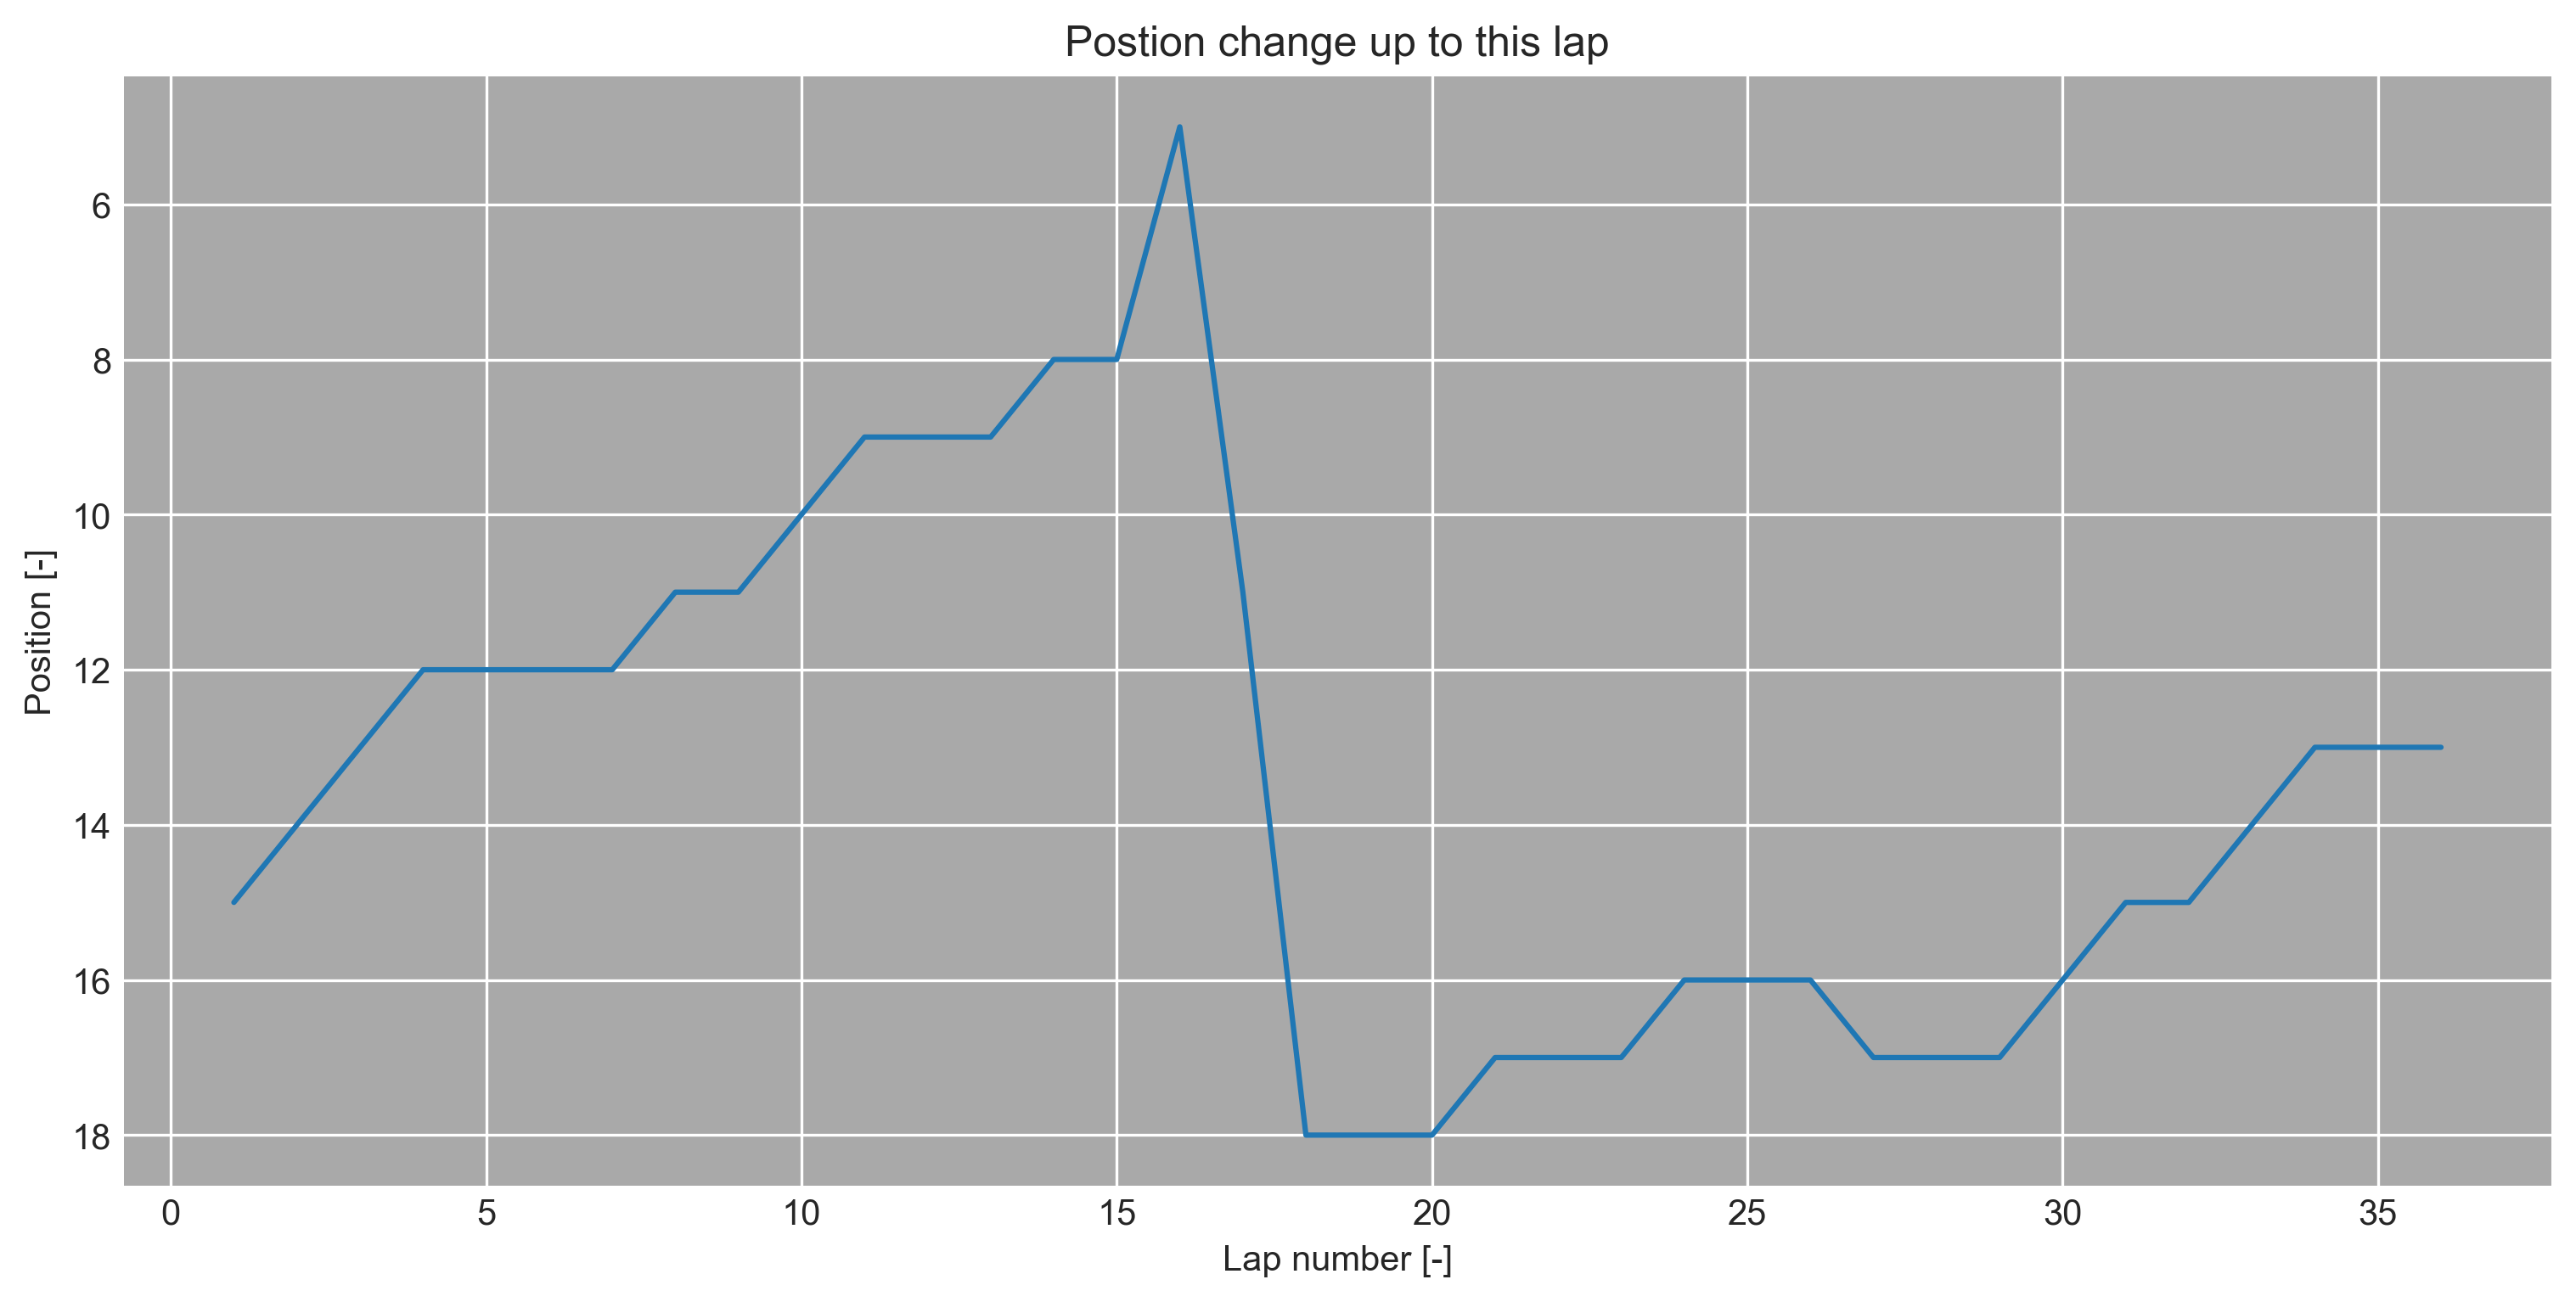

In [50]:
fig, axes = plt.subplots(figsize=(10, 5), dpi=300, layout='constrained')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
axes.set_title('Postion change up to this lap')
axes.set_xlabel('Lap number [-]')
axes.set_ylabel('Position [-]')
axes.invert_yaxis()

sns_data=df.loc[(df['Driver']==driver)&(df['LapNumber']<=36)]
sns.lineplot(data=sns_data,x='LapNumber',y='Position')

## Current vs best

In [23]:
def unite_legends(axes):
    h, l = [], []
    for ax in axes:
        tmp = ax.get_legend_handles_labels()
        h.extend(tmp[0])
        l.extend(tmp[1])
    return h, l

def difference(main_x,main_y,aux_x,aux_y):
    error=[]
    x_new=[]
    y_new=[]
    for x,y in zip(main_x,main_y):
        diff=[abs(x-x2) for x2 in aux_x]
        diff_min=min(diff)
        if diff_min<2:
            x_new.append(aux_x[diff.index(diff_min)])
            y_new.append(aux_y[diff.index(diff_min)]-y)
            error.append(diff_min)
    return x_new,y_new,error

def distance(x1,y1,x2,y2):
    dist=np.sqrt((x1-x2)**2+(y1-y2)**2)
    return dist

def v_diff(x1,y1,v1,x2,y2,v2):
    if len(x1)<len(x2):
        x_main=x1
        y_main=y1
        v_main=v1
        x_aux=x2
        y_aux=y2
        v_aux=v2
        direction=1
    else:
        x_main=x2
        y_main=y2
        v_main=v2
        x_aux=x1
        y_aux=y1
        v_aux=v1
        direction=-1
    v_diff_return=[]
    for x,y,v in zip(x_main,y_main,v_main):
        d=[distance(x,y,x_i,y_i) for x_i,y_i in zip(x_aux,y_aux)]
        if min(d)<1:
            idx=d.index(min(d))
            v_diff_return.append(v-v_aux[idx])
    return x_main,y_main,v_diff_return,direction

In [53]:
x=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'X'].iloc[0]
x = x.strip('][').split(', ')
x=[round(float(i)/10,0) for i in x]

y=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'Y'].iloc[0]
y = y.strip('][').split(', ')
y=[round(float(i)/10,0) for i in y]

v=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'Velocity'].iloc[0]
v = v.strip('][').split(', ')
v=[float(x) for x in v]

d=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'Distance'].iloc[0]
d = d.strip('][').split(', ')
d =[float(x)*100 for x in d]

tyre=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'Compound'].iloc[0]
t_life=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'TyreLife'].iloc[0]
c=df.loc[(df['Driver']==driver)&(df['LapNumber']==lap),'Color'].iloc[0]

lap_best=df['LapTime'].min()

x_best=df.loc[df['LapTime']==lap_best,'X'].iloc[0]
x_best = x_best.strip('][').split(', ')
x_best=[round(float(i)/10,0) for i in x_best]

y_best=df.loc[df['LapTime']==lap_best,'Y'].iloc[0]
y_best = y_best.strip('][').split(', ')
y_best=[round(float(i)/10,0) for i in y_best]

v_best=df.loc[df['LapTime']==lap_best,'Velocity'].iloc[0]
v_best = v_best.strip('][').split(', ')
v_best=[float(x) for x in v_best]

d_best=df.loc[df['LapTime']==lap_best,'Distance'].iloc[0]
d_best = d_best.strip('][').split(', ')
d_best=[float(x)*100 for x in d_best]

tyre_best=df.loc[df['LapTime']==lap_best,'Compound'].iloc[0]
t_life_best=df.loc[df['LapTime']==lap_best,'TyreLife'].iloc[0]
driver_best=df.loc[df['LapTime']==lap_best,'Driver'].iloc[0]
lap_no_best=df.loc[df['LapTime']==lap_best,'LapNumber'].iloc[0]
c_best=df.loc[df['LapTime']==lap_best,'Color'].iloc[0]

x_main,y_main,v_diff_contour,direction=v_diff(x,y,v,x_best,y_best,v_best)
v_diff_contour=[v_x*direction for v_x in v_diff_contour]

d_diff,v_diff_plot,error=difference(d_best,v_best,d,v)

### V(time) for current driver and lap vs V_best_overall_lap(time)

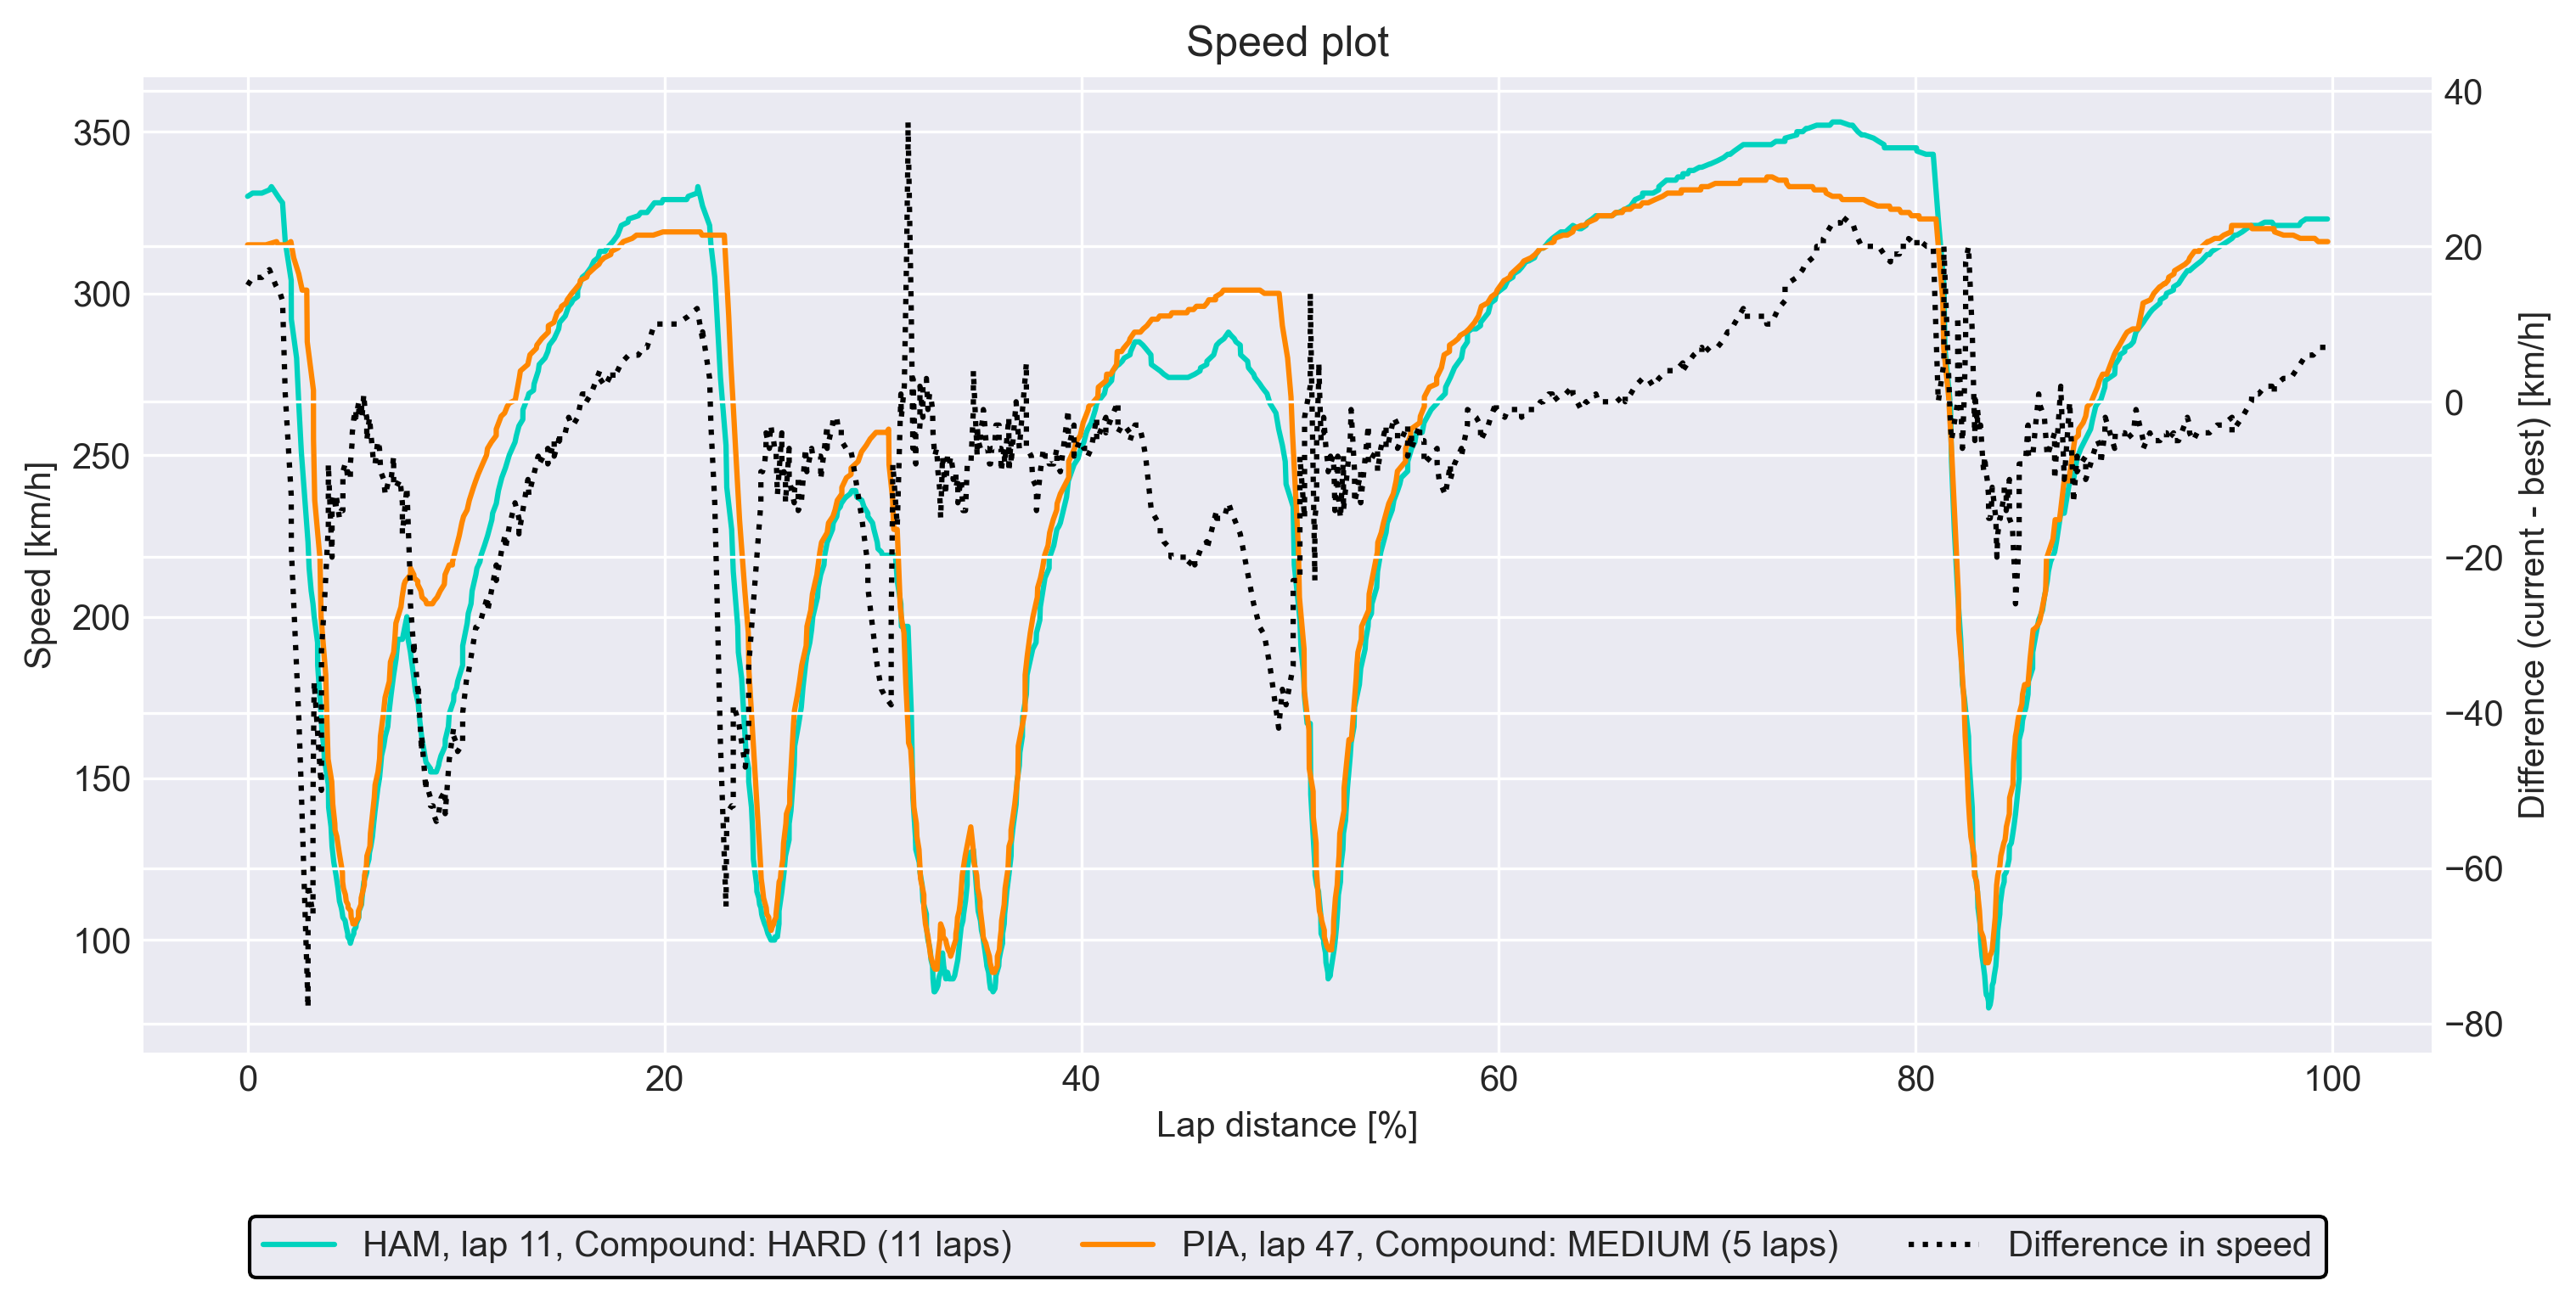

In [54]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(figsize=(10, 5), dpi=300, layout='constrained')
axes2 = axes.twinx()  
axes.set_title('Speed plot')
axes.set_xlabel('Lap distance [%]')
axes.set_ylabel('Speed [km/h]')
axes2.set_ylabel('Difference (current - best) [km/h]')

axes.plot(d, v, label=f'{driver}, lap {int(lap)}, Compound: {tyre} ({int(t_life)} laps)', c=c)
axes2.plot(d_diff,v_diff_plot, c='black', label='Difference in speed',ls='dotted')
axes.plot(d_best, v_best, label=f'{driver_best}, lap {int(lap_no_best)}, Compound: {tyre_best} ({int(t_life_best)} laps)', c=c_best)

handles, labels = unite_legends([axes, axes2])
# ... HERE YOU SHOULD USE LAST axes INITIALIZED. IN THIS CASE IT'S axes_r
axes2.legend(handles, labels, ncols=3, loc='upper center', framealpha=1,
         frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.15))

### V_lap-V-best as contour on circuit

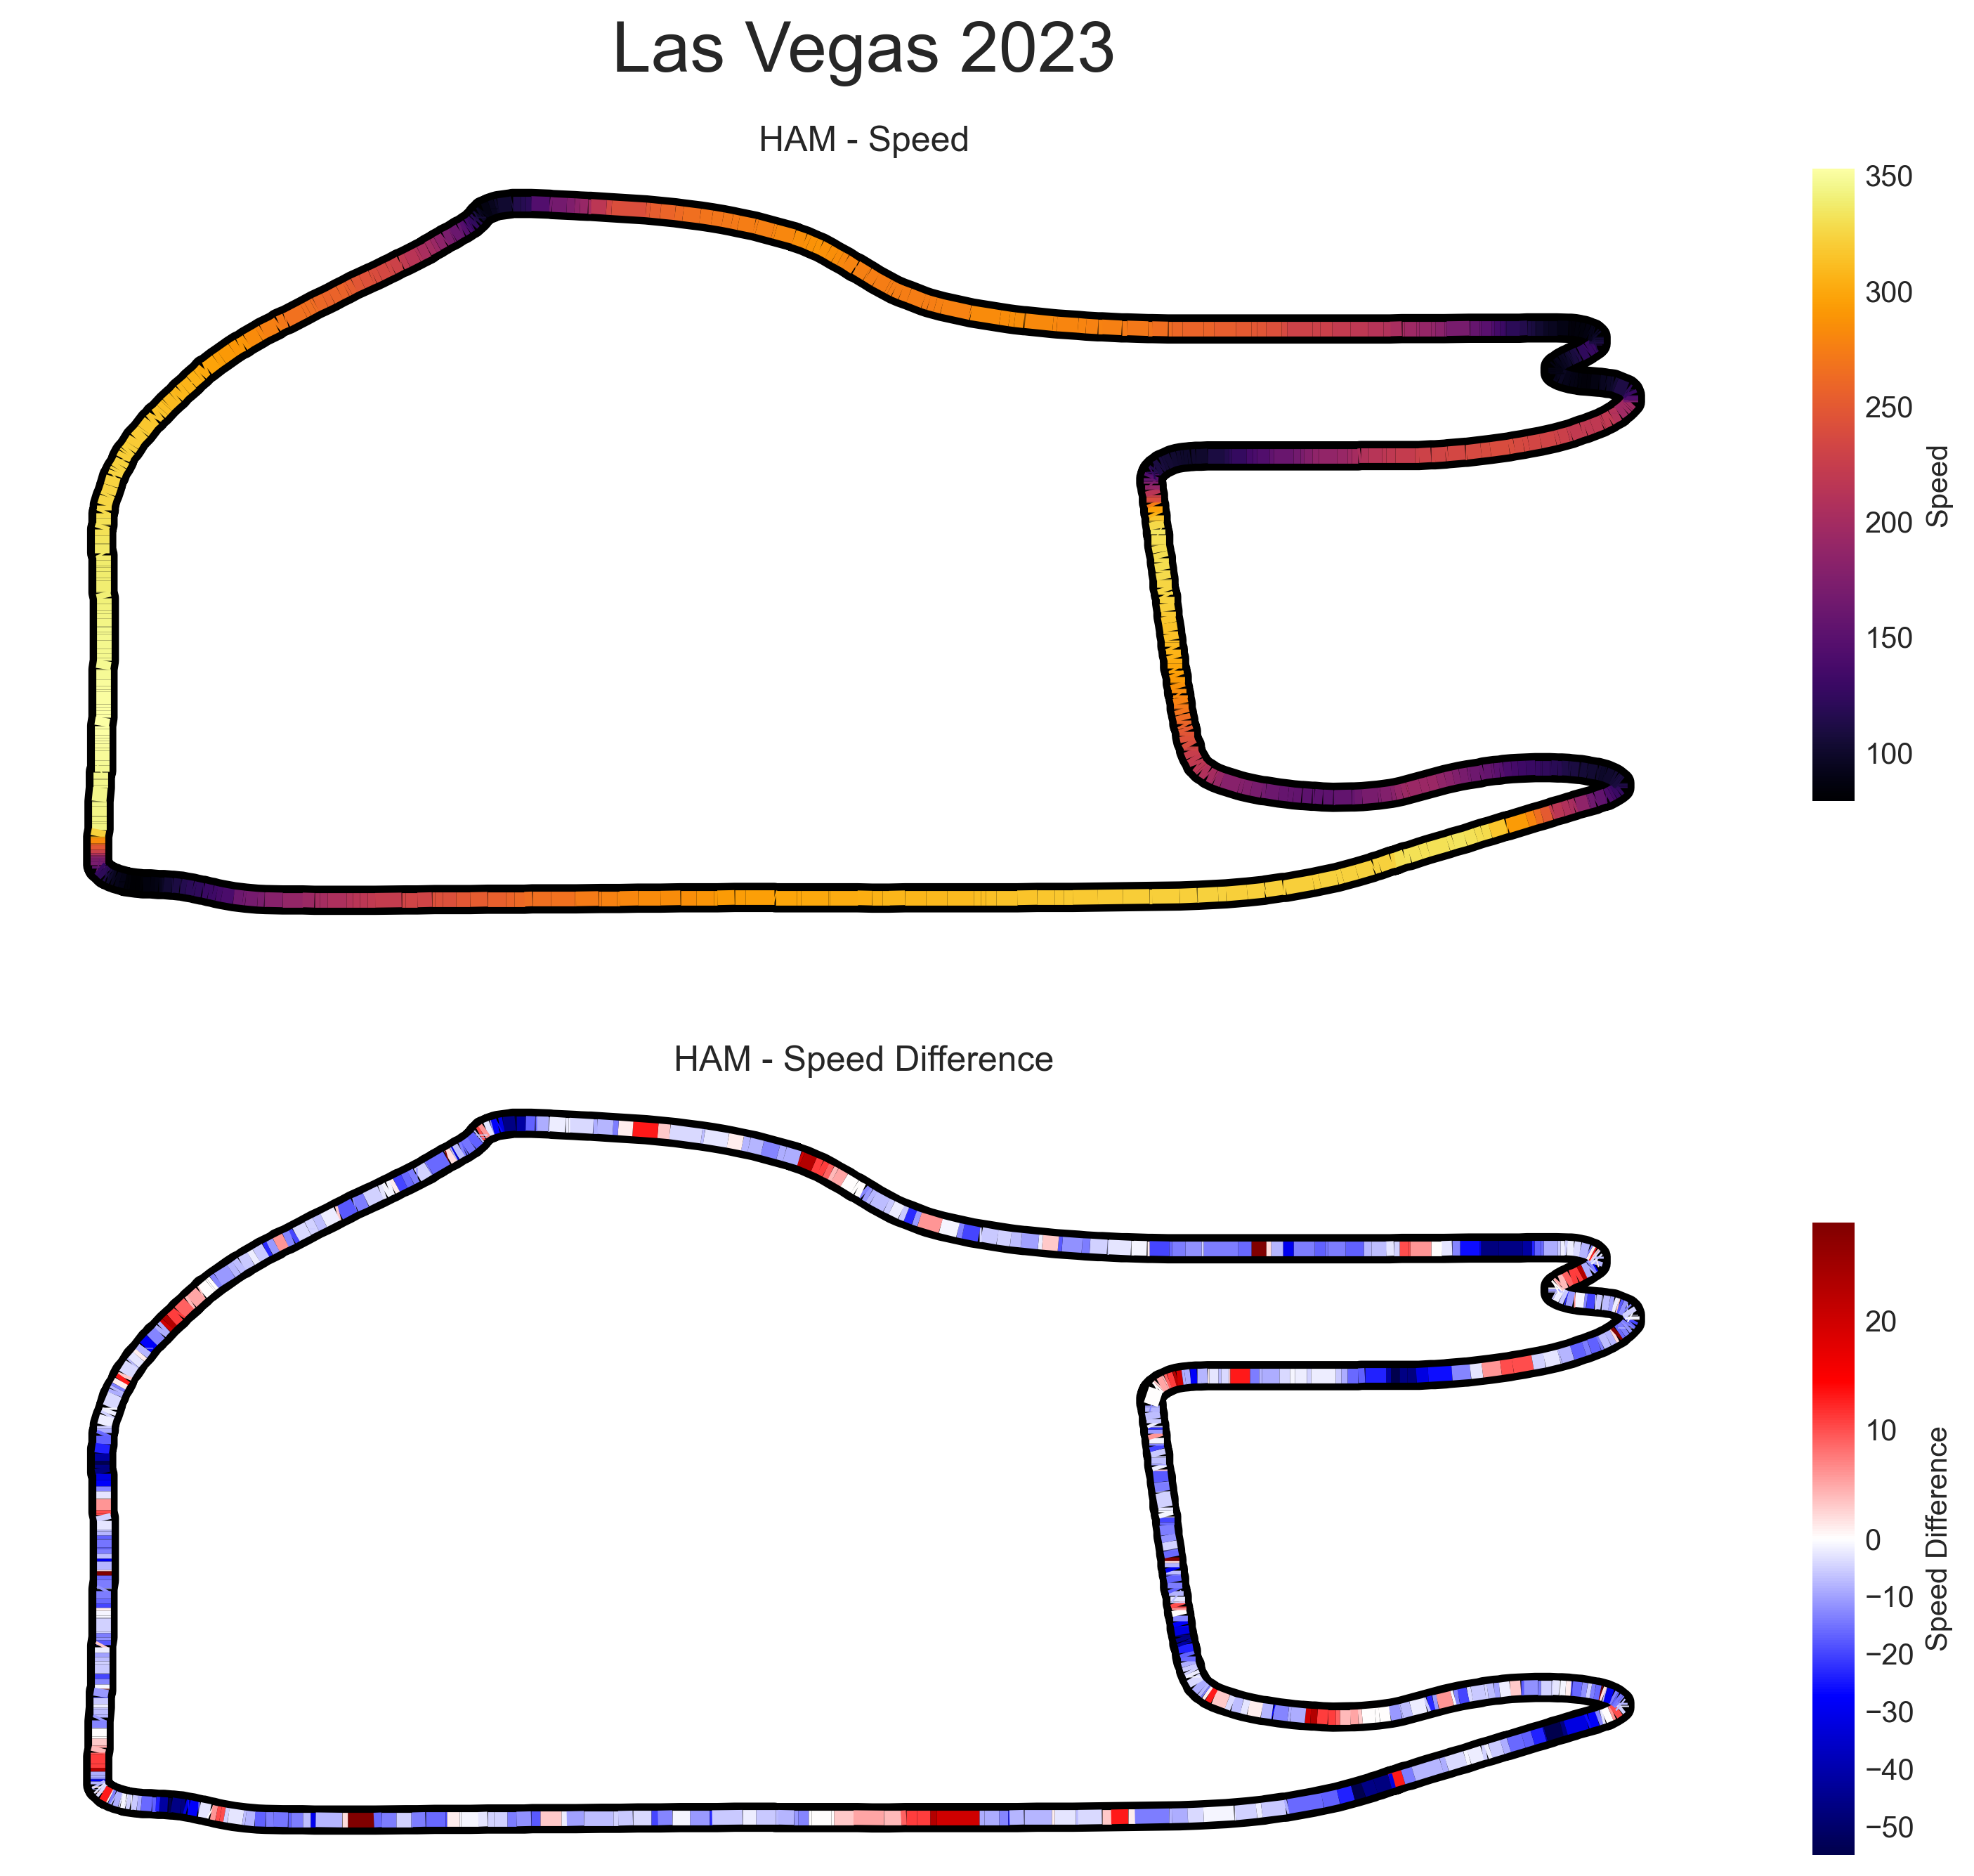

In [55]:
colormap = mpl.cm.inferno
colormap1= mpl.cm.seismic
divnorm= mpl.colors.TwoSlopeNorm(vmin=float(min(v_diff_contour)), vcenter=0., vmax=float(max(v_diff_contour)))
# Get telemetry data


##############################################################################
# Now, we create a set of line segments so that we can color them
# individually. This creates the points as a N x 1 x 2 array so that we can
# stack points  together easily to get the segments. The segments array for
# line collection needs to be (numlines) x (points per line) x 2 (for x and y)
points0 = np.array([x, y]).T.reshape(-1, 1, 2)
segments0 = np.concatenate([points0[:-1], points0[1:]], axis=1)

points1 = np.array([x_main, y_main]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)

##############################################################################
# After this, we can actually plot the data.

# We create a plot with title and adjust some setting to make it look good.
fig, axes = plt.subplots(figsize=(10, 10),nrows=2, dpi=300,sharex=True, sharey=True)
fig.suptitle(f'{event} 2023', size=24, y=0.97)
axes[0].set_title(f'{driver} - Speed')
axes[1].set_title(f'{driver} - Speed Difference')
# Adjust margins and turn of axis
axes[0].axis('off')
axes[1].axis('off')

# After this, we plot the data itself.
# Create background track line
axes[0].plot(x, y, color='black', linestyle='-', linewidth=10, zorder=0)
axes[1].plot(x, y, color='black', linestyle='-', linewidth=10, zorder=0)

# Create a continuous norm to map from data points to colors
norm0 = plt.Normalize(min(v), max(v))
lc0 = LineCollection(segments0, cmap=colormap, norm=norm0, linestyle='-', linewidth=5)

norm1 = plt.Normalize(min(v_diff_contour), max(v_diff_contour))
lc1 = LineCollection(segments1, cmap=colormap1, norm=divnorm, linestyle='-', linewidth=5)

# Set the values used for colormapping
lc0.set_array(v)
lc1.set_array(v_diff_contour)

# Merge all line segments together
#line0 = axes[0].add_collection(lc0)
axes[0].add_collection(lc0)
line1 = axes[1].add_collection(lc1)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Finally, we create a color bar as a legend.
cbaxes0 = fig.add_axes([0.95, 0.60, 0.02, 0.30])
cbaxes1 = fig.add_axes([0.95, 0.10, 0.02, 0.30])
normlegend0 = mpl.colors.Normalize(vmin=min(v), vmax=max(v))
#normlegend1 = mpl.colors.Normalize(vmin=min(v_diff_contour), vmax=max(v_diff_contour))
legend0 = mpl.colorbar.ColorbarBase(norm=normlegend0, cmap=colormap, orientation="vertical",ax=cbaxes0)
legend1 = mpl.colorbar.ColorbarBase(norm=divnorm, cmap=colormap1, orientation="vertical",ax=cbaxes1)


legend0.set_label('Speed')
legend1.set_label('Speed Difference')

#### Divide 1

In [ ]:
points0 = np.array([x, y]).T.reshape(-1, 1, 2)
segments0 = np.concatenate([points0[:-1], points0[1:]], axis=1)

##############################################################################
# After this, we can actually plot the data.

# We create a plot with title and adjust some setting to make it look good.
fig, axes = plt.subplots(figsize=(10, 10), dpi=300)
axes.set_title(f'{driver} - Speed')

# Adjust margins and turn of axis
axes.axis('off')

# After this, we plot the data itself.
# Create background track line
axes.plot(x, y, color='black', linestyle='-', linewidth=10, zorder=0)

# Create a continuous norm to map from data points to colors
norm0 = plt.Normalize(min(v), max(v))
lc0 = LineCollection(segments0, cmap=colormap, norm=norm0, linestyle='-', linewidth=5)

# Set the values used for colormapping
lc0.set_array(v)

# Merge all line segments together
axes.add_collection(lc0)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

cbar = plt.colorbar(lc0, ax=axes)
cbar.set_label('Speed')

## Laptimes of current lap comparing tyres (boxplot)

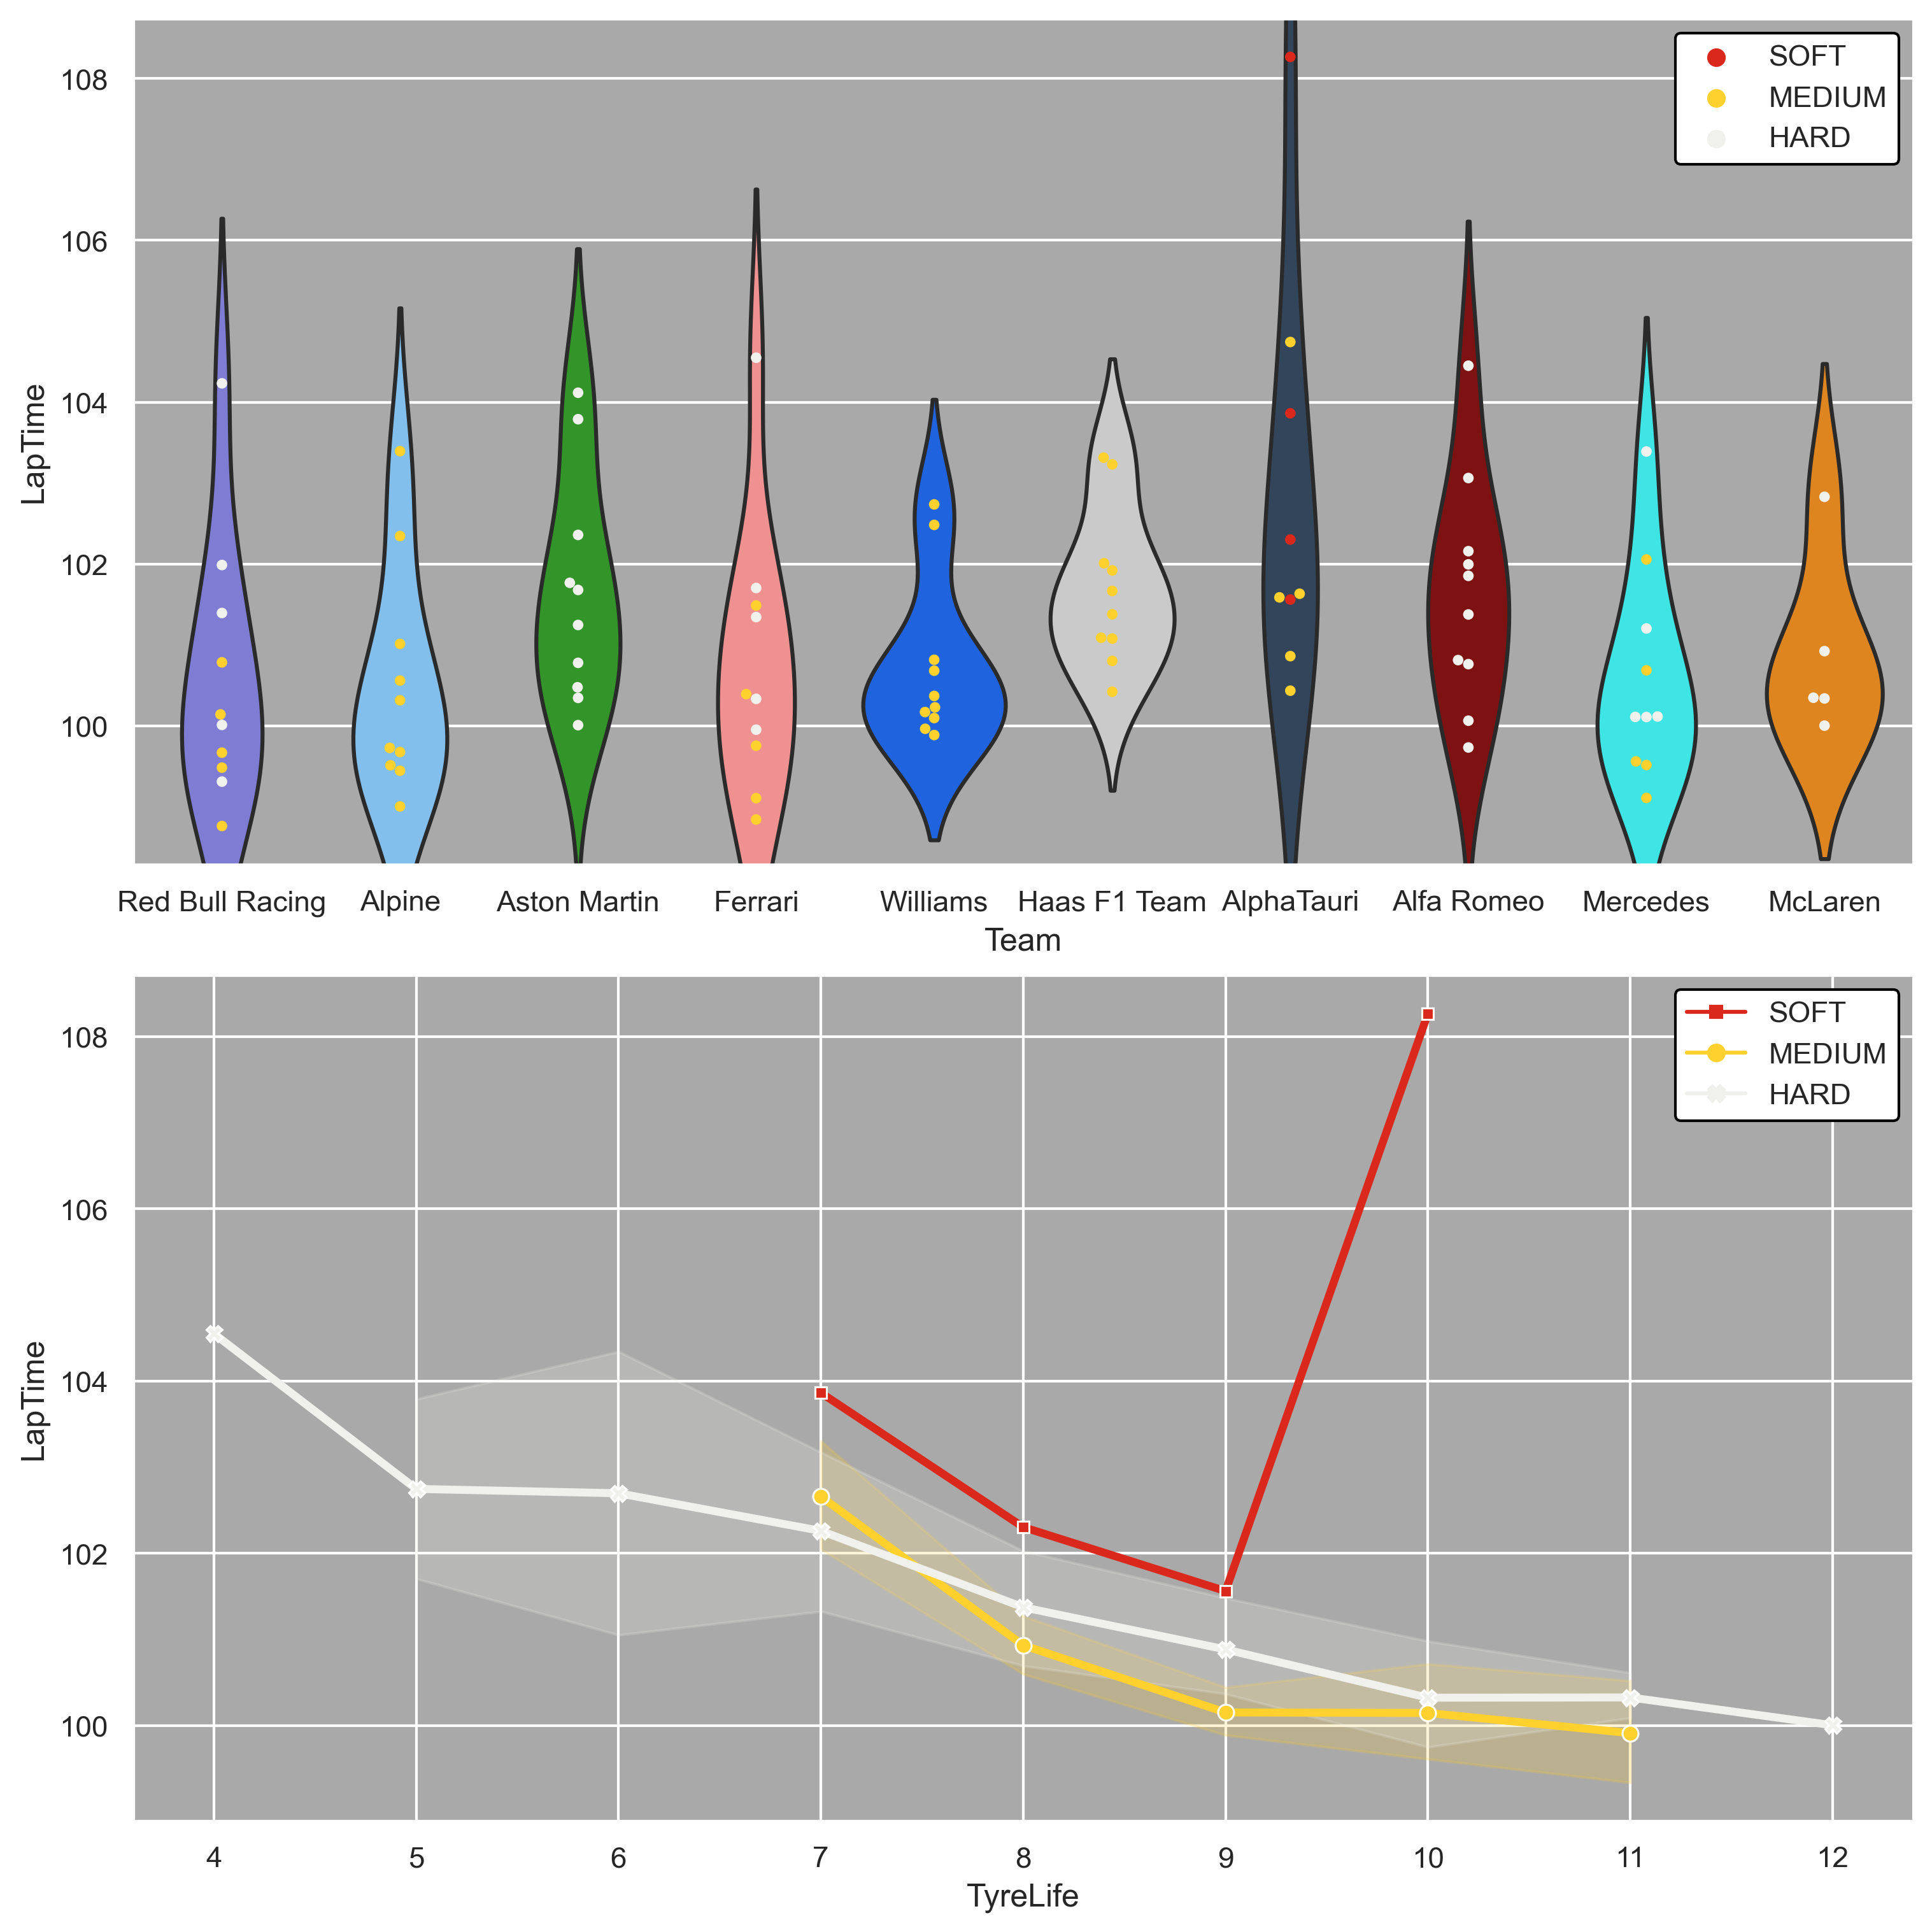

In [15]:
colors = ['#ed1909', '#c9c924', '#ababa9']
#rgba_colors = [to_rgba(color) for color in colors]
sns.set_theme(style="darkgrid")
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
fig, axes = plt.subplots(figsize=(10, 10),nrows=2, dpi=300, layout='constrained')

df_box=df.loc[(df['LapNumber']<=lap)&(df['LapNumber']>1)&(df['TrackStatus']==1)&(df['PitOutTime'].isnull())]

groups = df_box['Team'].tolist()
colors = df_box['Color'].tolist()
team_colors = {team: col for team,col in zip(groups, colors)}

sns.violinplot(data=df_box,
               x="Team",
               y="LapTime",
               inner=None,
               #scale="area",
               density_norm='area',
               palette=team_colors.values(),ax=axes[0]
               )

sns.swarmplot(data=df_box,
              x="Team",
              y="LapTime",
              hue="Compound",
              palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              size=4,ax=axes[0]
              )

sns.lineplot(data=df_box,x='TyreLife',y='LapTime',
             style='Compound',hue='Compound',lw=3,
             ax=axes[1],
             palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"],
             markers=True, dashes=False,#estimator=None,
            )
axes[0].legend(framealpha=1,frameon=True, facecolor='white', edgecolor='black')
axes[1].legend(framealpha=1,frameon=True, facecolor='white', edgecolor='black')

## V_avg vs V_max for different teams

In [364]:
df.loc[df['Driver']=='LEC','Color'].iloc[0]

'#dc0000'

<Axes: xlabel='Mean Speed', ylabel='Max Speed'>

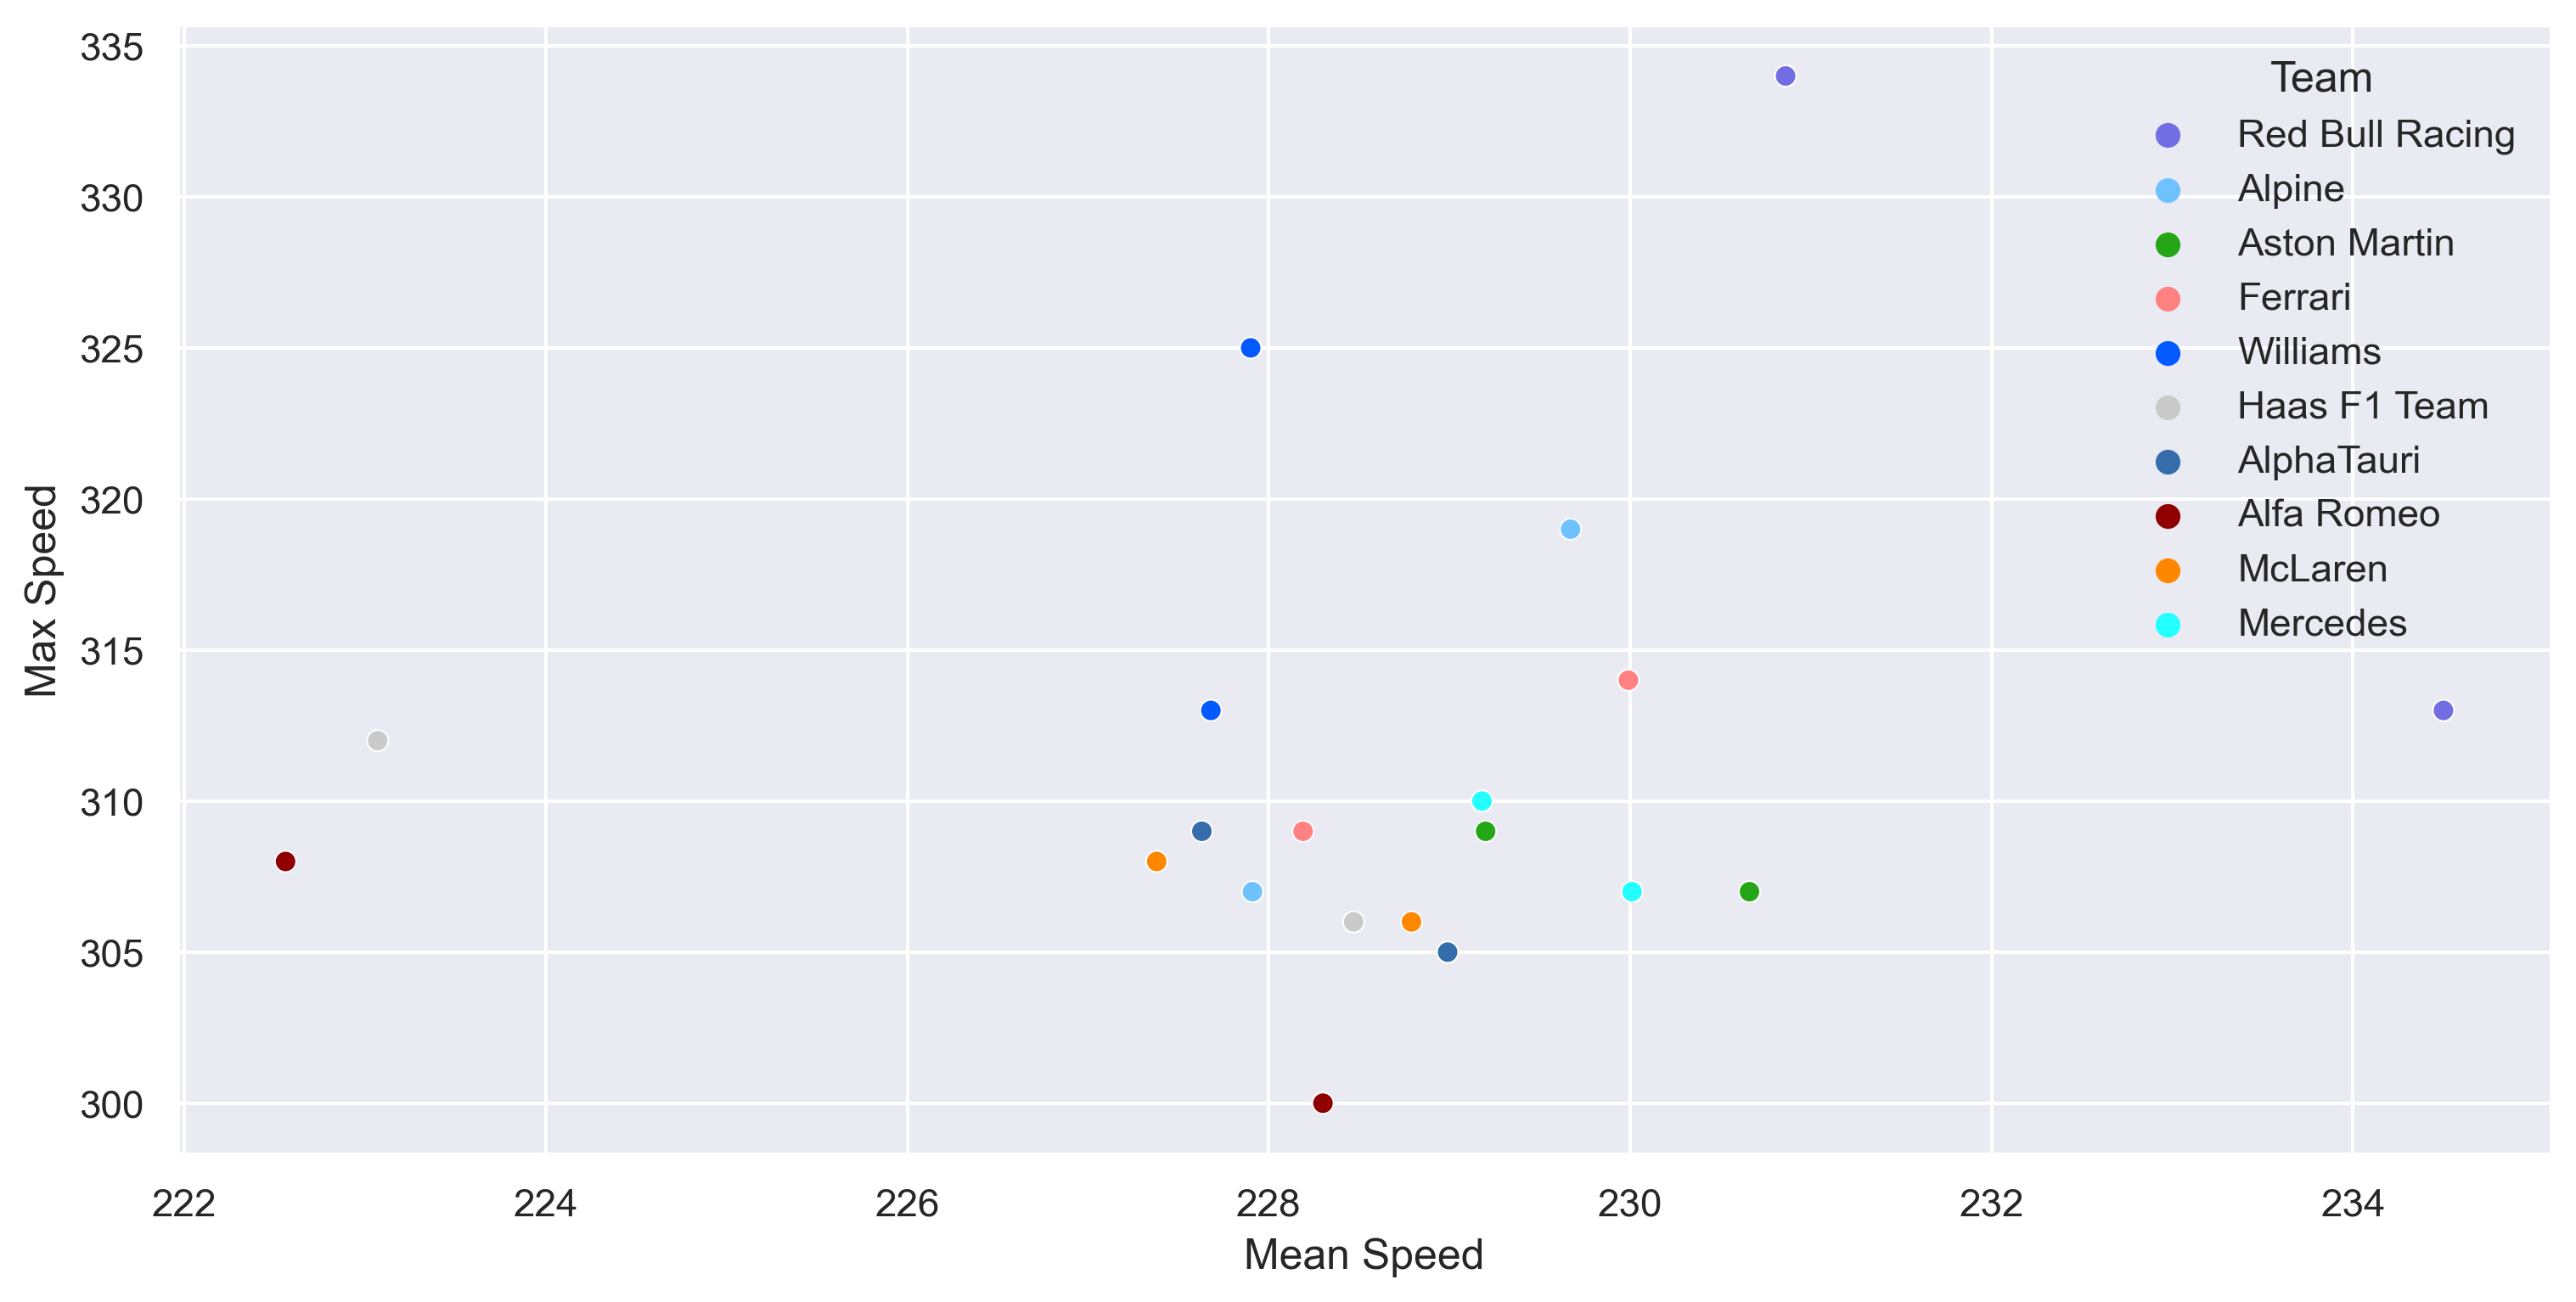

In [368]:
fig, axes = plt.subplots(figsize=(10, 5),dpi=300, layout='constrained')

# Your data and groups
df_box = df.loc[df['LapNumber'] == lap]
groups = df_box['Team'].tolist()
colors = df_box['Color'].tolist()

team_colors = {team: col for team,col in zip(groups, colors)}

# Extract unique hex values from the 'Color' column
hex_values = df_box['Color'].unique()

# Create a custom palette using the extracted hex values
custom_palette = sns.color_palette(hex_values, n_colors=len(hex_values))

# Your scatterplot code
sns.scatterplot(data=df_box, x='Mean Speed', y='Max Speed', hue='Team', palette=team_colors.values(),ax=axes)

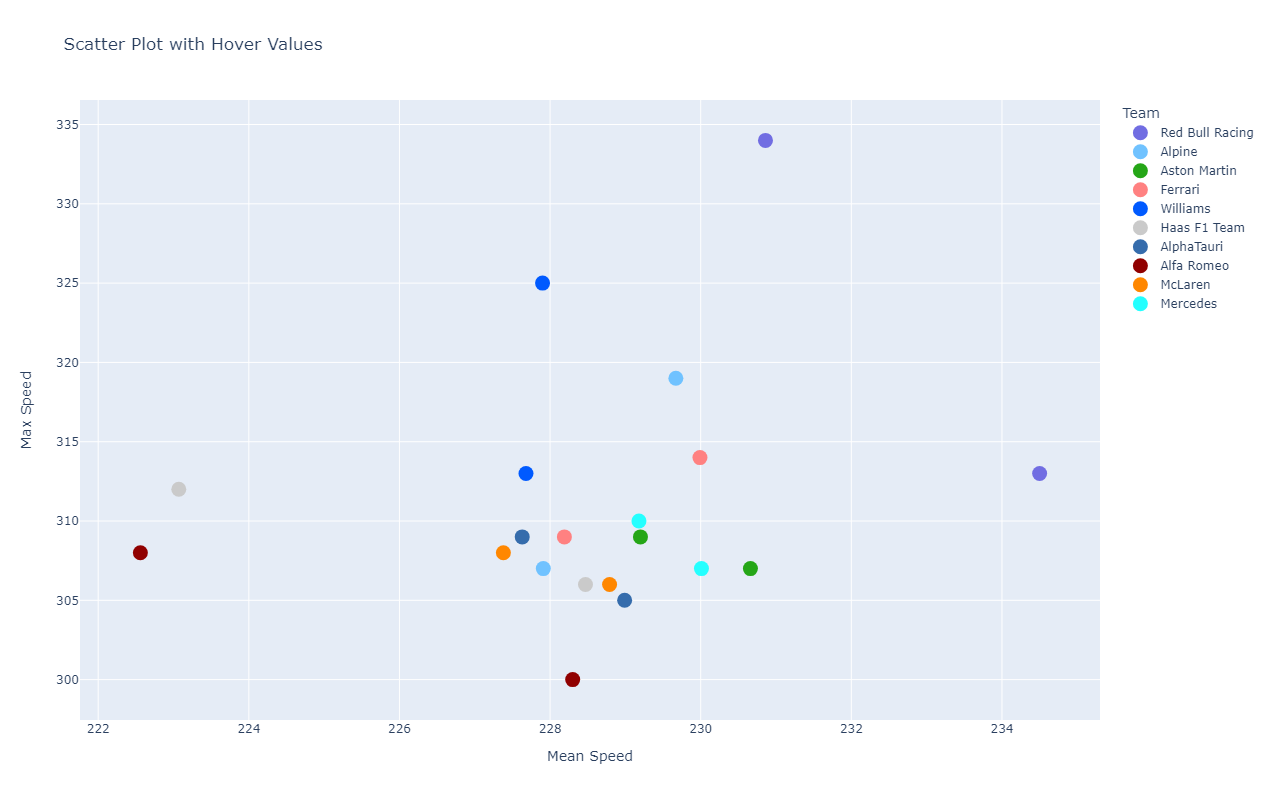

In [383]:
fig = px.scatter(
    df_box,
    x='Mean Speed',
    y='Max Speed',
    color='Team',
    hover_name='Driver',  # Display team name when hovering
    hover_data={'Driver': True, 'Team': True,'Color':False},  # Display driver and team in hover
    color_discrete_map=team_colors,  # Map team names to colors
    title='Scatter Plot with Hover Values',
    width=1200,  # Specify the width of the figure in pixels
    height=800,  # Specify the height of the figure in pixels
)
fig.update_traces(marker_size=15)
fig.show()